# Masked Face Detector
---
Masked and partially or fully unmasked face detector with application of:
* **pretrained PyTorch model** for face detection
* **Haar Cascade Classifiers** for eyes, mouths and noses detection
* **HOG Facial Landmarks** for jawline and foreheadline detection (lower and upper borders of face); also in order to get mask of a part of restriction area above the line marked by two eyes alignment
* **Human Skin Detector** (with **brightness & contrast minapulation**) for estimation of masked face percentage

**Final result** at the end.

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from src.face_detector import inference
from src.human_silhouette_detector import detect_human_silhouettes, detect_human_silhouettes_and_faces
from src.haar_detector import detect_face_parts
from src.brightness_contrast import change_brightness_contrast, clahe, equalize_histogram, gaussian_blur
from src.facial_landmarks_detector import detect_facial_landmarks, get_face_between_jaw_and_forehead
from src.human_skin_detector import detect_skin
from src.perc_calculation import calculate_masking_percentage, draw_roi
from src.visualize import show_images

from src.example import example

/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'MainModel.KitModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by access

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

## Silhouette and face detectors
---
PyTorch pretrained silhouette and face detection models.

**iu** - *image unmasked*  |  **im** - *image masked*<br />
**uf_info** - *unmasked faces info*  |  **mf_info** - *masked faces info*<br />
**ufi** - *unmasked faces image*  |  **mfi** - *masked faces image*<br />
<br />
**fu** - *face unmasked*  |  **fm** - *face masked*<br />

In [3]:
iu = Image.open('images/masked_people3.jpg')
_, ufi = detect_human_silhouettes(iu)

im = Image.open('images/masked_people2.jpg')
_, mfi = detect_human_silhouettes(im)

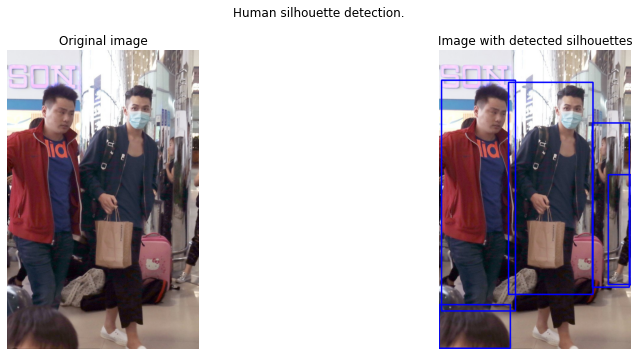

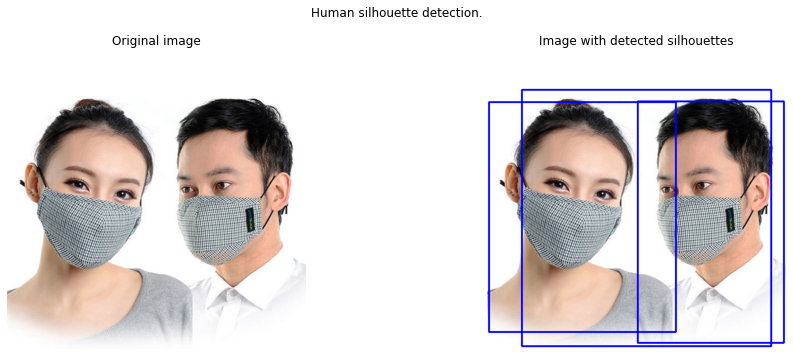

In [4]:
show_images([iu, ufi],
            ['Original image', 'Image with detected silhouettes'],
            suptitle='Human silhouette detection.')

show_images([im, mfi],
            ['Original image', 'Image with detected silhouettes'],
            suptitle='Human silhouette detection.')

In [5]:
uf_info, _, ufi = detect_human_silhouettes_and_faces(
    iu, highlight_neg=True)

mf_info, _, mfi = detect_human_silhouettes_and_faces(
    im, highlight_neg=True)

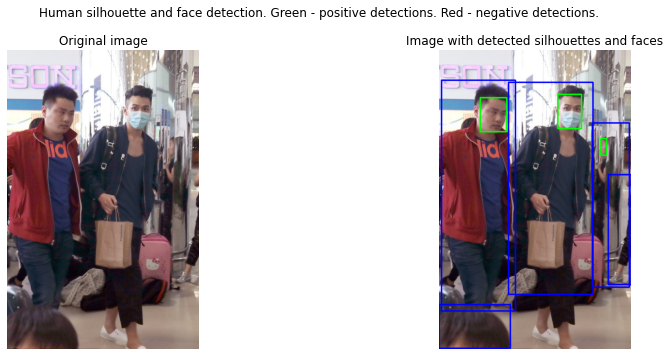

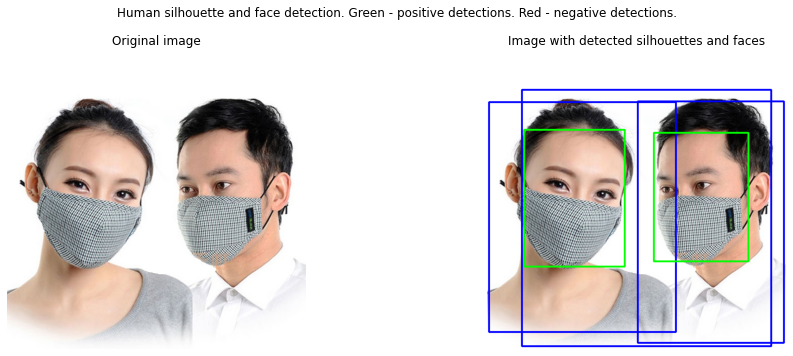

In [6]:
show_images([iu, ufi],
            ['Original image', 'Image with detected silhouettes and faces'],
            suptitle='Human silhouette and face detection. Green - positive detections. Red - negative detections.')

show_images([im, mfi],
            ['Original image', 'Image with detected silhouettes and faces'],
            suptitle='Human silhouette and face detection. Green - positive detections. Red - negative detections.')

In [7]:
uf_info, mf_info

(array([[395, 147, 474, 261],
        [137, 158, 225, 271],
        [538, 294, 557, 349]]),
 array([[446, 221, 699, 565],
        [ 99, 213, 368, 579]]))

In [8]:
fu = iu.crop(tuple(uf_info[1]))

fm = im.crop(tuple(mf_info[1]))

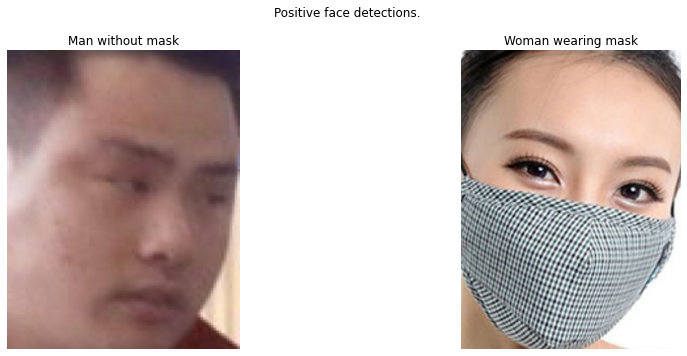

In [9]:
show_images([fu, fm], ['Man without mask', 'Woman wearing mask'],
            suptitle='Positive face detections.')

## Haar Cascade Classifiers

**fup_info** - *face unmasked parts info*  |  **fmp_info** - *face masked parts info*<br />
**fup** - *face unmasked parts*  |  **fmp** - *face masked parts*<br />

In [10]:
fup_info, fup = detect_face_parts(fu)

fmp_info, fmp = detect_face_parts(fm)

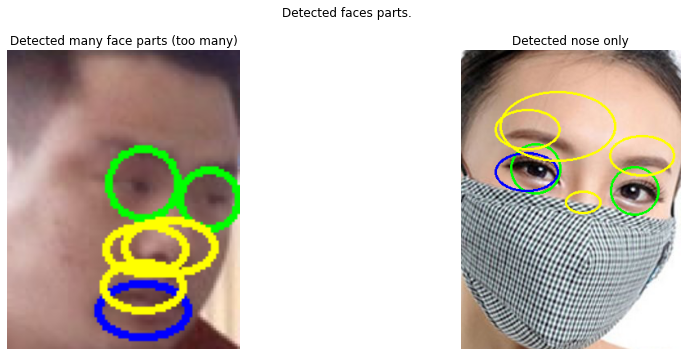

In [11]:
show_images([fup, fmp], ['Detected many face parts (too many)', 'Detected nose only'], suptitle='Detected faces parts.')

In [12]:
fup_info, fmp_info

({'eyes': [((38, 37), (65, 64)), ((65, 45), (87, 67))],
  'mouths': [((34, 88), (69, 109))],
  'noses': [((37, 66), (67, 84)), ((44, 64), (78, 85)), ((36, 80), (66, 98))]},
 {'eyes': [((61, 115), (122, 176)), ((183, 143), (241, 201))],
  'mouths': [((42, 126), (119, 172))],
  'noses': [((128, 173), (170, 199)),
   ((42, 73), (121, 121)),
   ((48, 51), (188, 135)),
   ((182, 105), (261, 153))]})

## HOG Facial Landmarks

**ful_info** - *face unmasked landmarks info*  |  **fml_info** - *face masked landmarks info*<br />
**ful** - *face unmasked landmarks*  |  **fml** - *face masked landmarks*<br />
**fu_pts** - *face unmasked restriction points*  |  **fm_pts** - *face masked restriction points*<br />
**fu_roi** - *face unmasked restriction RoI*  |  **fm_roi** - *face masked restriction RoI*<br />
**fu_rm** - *face unmasked restriction mask*  |  **fm_rm** - *face masked restriction mask*<br />
**fu_aem** - *face unmasked above eyes mask*  |  **fm_aem** - *face masked above eyes mask*<br />
**fu_rf** - *face unmasked restricted face*  |  **fm_rf** - *face masked restricted face*<br />

In [13]:
ful_info, ful = detect_facial_landmarks(fu)

fml_info, fml = detect_facial_landmarks(fm)

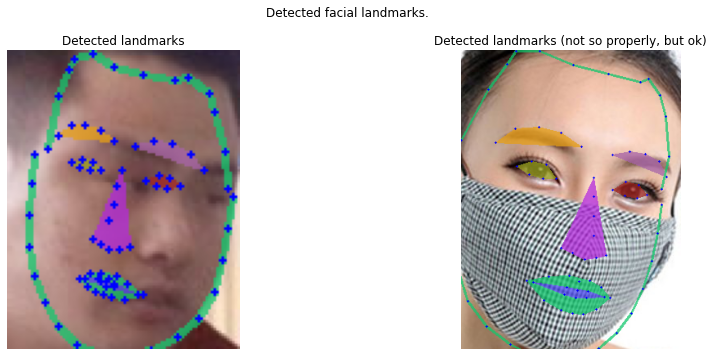

In [14]:
show_images([ful, fml],
            ['Detected landmarks', 'Detected landmarks (not so properly, but ok)'], suptitle='Detected facial landmarks.')

In [15]:
ful_info['jaw'][:5], fml_info['jaw'][:5]

([(10, 39), (9, 50), (8, 62), (8, 74), (10, 85)],
 [(-5, 125), (-7, 173), (-8, 220), (-5, 265), (8, 307)])

In [16]:
ful_info['forehead'][:5], fml_info['forehead'][:5]

([(83, 52), (82, 38), (78, 23), (76, 16), (68, 10)],
 [(245, 170), (254, 130), (250, 81), (243, 55), (229, 35)])

In [17]:
ful_info['left_eye'], fml_info['left_eye']

([(52, 49), (57, 47), (61, 48), (65, 51), (60, 52), (56, 51)],
 [(185, 171), (201, 161), (217, 165), (227, 177), (215, 181), (200, 178)])

In [18]:
ful_info['right_eye'], fml_info['right_eye']

([(24, 42), (28, 41), (32, 42), (35, 45), (31, 45), (27, 44)],
 [(68, 142), (86, 136), (104, 140), (116, 157), (100, 157), (83, 152)])

In [19]:
fu_pts, fu_roi, fu_rm, fu_aem, fu_rf = get_face_between_jaw_and_forehead(
    fu, ful_info['jaw'], ful_info['forehead'], ful_info['left_eye'], ful_info['right_eye'], draw_roi=True)

fm_pts, fm_roi, fm_rm, fm_aem, fm_rf = get_face_between_jaw_and_forehead(
    fm, fml_info['jaw'], fml_info['forehead'], fml_info['left_eye'], fml_info['right_eye'], draw_roi=True)

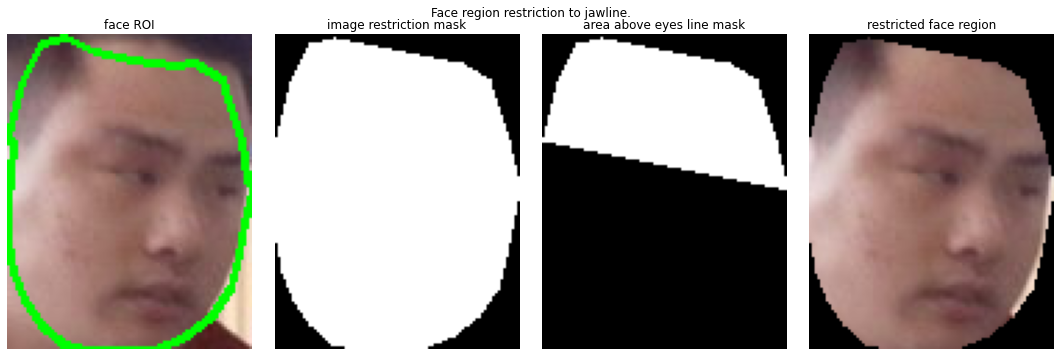

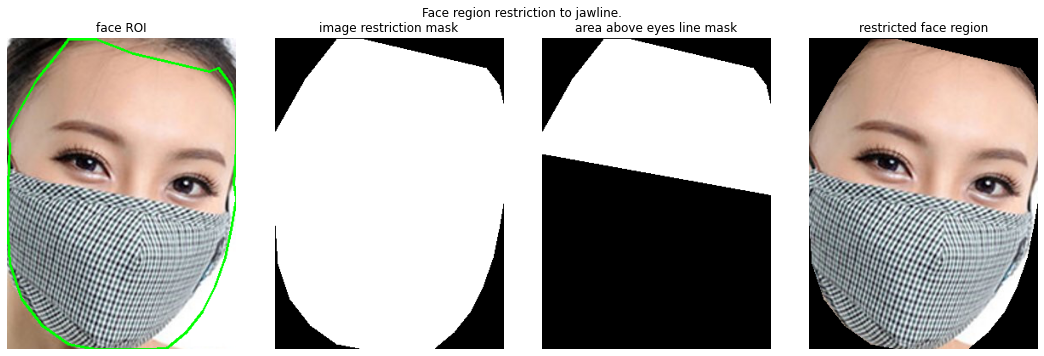

In [20]:
show_images([fu_roi, fu_rm, fu_aem, fu_rf],
            ['face ROI', 'image restriction mask', 'area above eyes line mask', 'restricted face region'],
            suptitle='Face region restriction to jawline.')

show_images([fm_roi, fm_rm, fm_aem, fm_rf],
            ['face ROI', 'image restriction mask', 'area above eyes line mask', 'restricted face region'],
            suptitle='Face region restriction to jawline.')

## Brightness and Contrast change
Reduce brightness and raise contrast.

**fu_bc** - *face unmasked B&C changed*  |  **fm_bc** - *face masked B&C changed*<br />
**fu_clahe** - *face unmasked CLAHE*  |  **fm_clahe** - *face masked CLAHE*<br />
**fu_he** - *face unmasked histogram equalized*  |  **fm_he** - *face masked histogram equalized*<br />
**fu_gauss** - *face unmasked gaussian blur*  |  **fm_gauss** - *face masked gaussian blur*<br />

In [21]:
BRIGHTNESS = 180
CONTRAST = 180

In [22]:
fu_bc = change_brightness_contrast(fu, brightness=BRIGHTNESS, contrast=CONTRAST)
fm_bc = change_brightness_contrast(fm, brightness=BRIGHTNESS, contrast=CONTRAST)

fu_clahe = clahe(fu)
fm_clahe = clahe(fm)

fu_he = equalize_histogram(fu)
fm_he = equalize_histogram(fm)

fu_gauss = gaussian_blur(fu)
fm_gauss = gaussian_blur(fm)

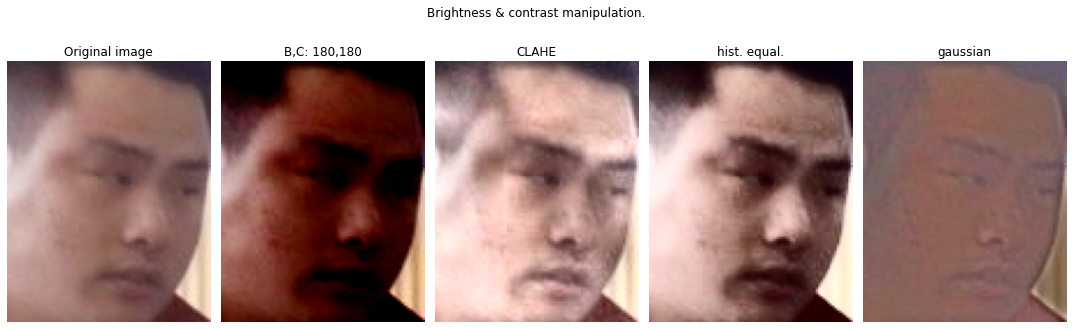

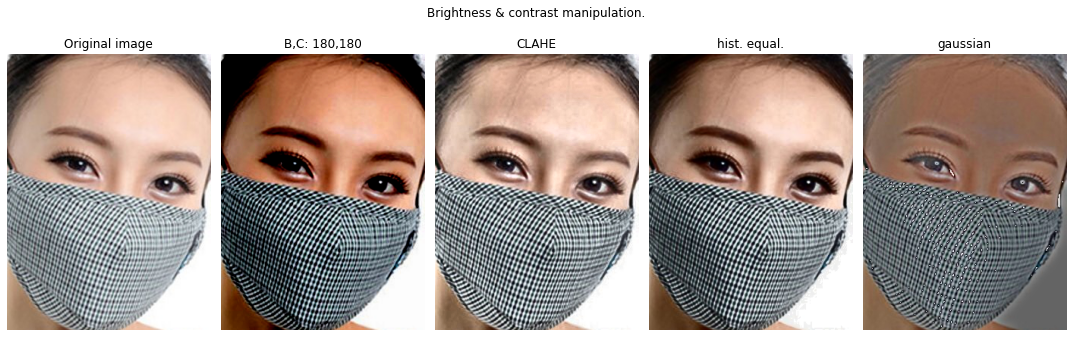

In [23]:
show_images([fu, fu_bc, fu_clahe, fu_he, fu_gauss],
            ['Original image', 'B,C: 180,180', 'CLAHE', 'hist. equal.', 'gaussian'],
            suptitle='Brightness & contrast manipulation.')

show_images([fm, fm_bc, fm_clahe, fm_he, fm_gauss],
            ['Original image', 'B,C: 180,180', 'CLAHE', 'hist. equal.', 'gaussian'],
            suptitle='Brightness & contrast manipulation.')

## Human Skin Detection

**fu_sm_none** - *face unmasked skin mask without B&C change*  |  **fm_sm_none** - *face masked skin mask without B&C change*<br />
**fu_sm_bc180** - *face unmasked skin mask with B&C change*  |  **fm_sm_bc180** - *face masked skin mask with B&C change*<br />
**fu_sm_clahe** - *face unmasked skin mask with CLAHE*  |  **fm_sm_clahe** - *face masked skin mask with CLAHE*<br />
**fu_sm_he** - *face unmasked skin mask with hist. eq.*  |  **fm_sm_he** - *face masked skin mask with hist. eq.*<br />
**fu_sm_gauss** - *face unmasked skin mask with gaussian blur*  |  **fm_sm_gauss** - *face masked skin mask with gaussian blur*<br />

In [24]:
_, fu_sm_none, _ = detect_skin(fu, bc=None)
_, fm_sm_none, _ = detect_skin(fm, bc=None)

_, fu_sm_bc180, _ = detect_skin(fu, bc=fu_bc)
_, fm_sm_bc180, _ = detect_skin(fm, bc=fm_bc)

_, fu_sm_clahe, _ = detect_skin(fu, bc=fu_clahe)
_, fm_sm_clahe, _ = detect_skin(fm, bc=fm_clahe)

_, fu_sm_he, _ = detect_skin(fu, bc=fu_he)
_, fm_sm_he, _ = detect_skin(fm, bc=fm_he)

_, fu_sm_gauss, _ = detect_skin(fu, bc=fu_gauss)
_, fm_sm_gauss, _ = detect_skin(fm, bc=fm_gauss)

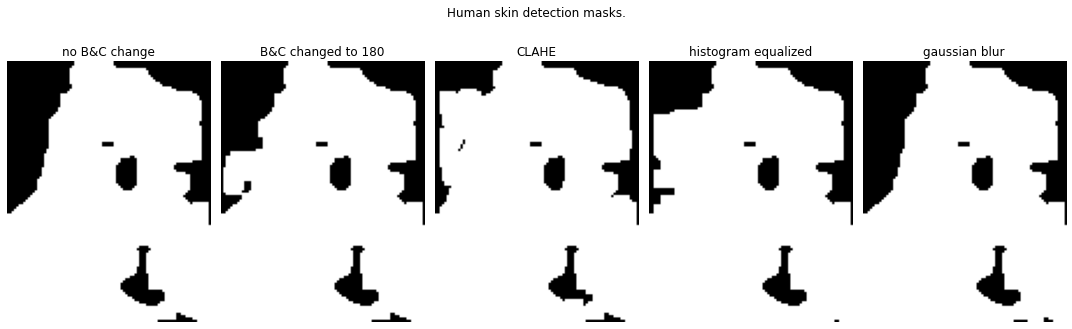

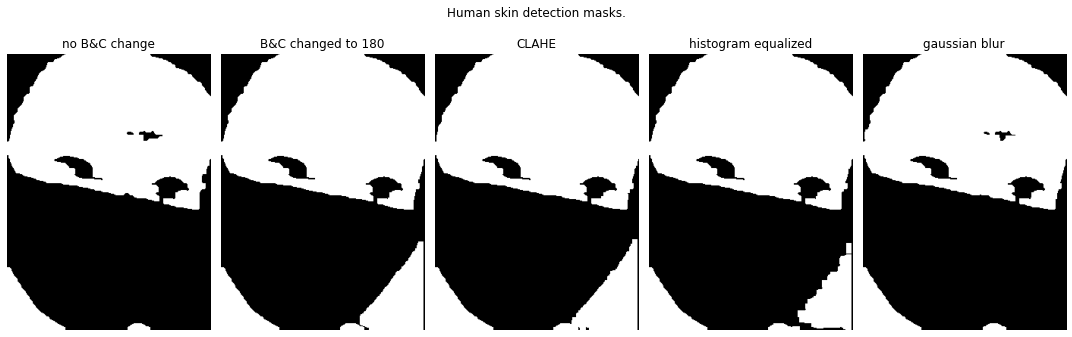

In [25]:
show_images([fu_sm_none, fu_sm_bc180, fu_sm_clahe, fu_sm_he, fu_sm_gauss],
            ['no B&C change', 'B&C changed to 180', 'CLAHE', 'histogram equalized', 'gaussian blur'],
            suptitle='Human skin detection masks.')

show_images([fm_sm_none, fm_sm_bc180, fm_sm_clahe, fm_sm_he, fm_sm_gauss],
            ['no B&C change', 'B&C changed to 180', 'CLAHE', 'histogram equalized', 'gaussian blur'],
            suptitle='Human skin detection masks.')

## Percentage of face masking calculation
---
In order to calculate the percentage of face masking it is necessary to:
1. Take the Haar Cascade detected face parts (true and false detections), which rectangles contain at least 80% of skin detected by Human Skin Detector.
2. Make areas marked by above regions white.
3. Perform bitwise "and" operation on masks for restricted face and detected skin.
4. Get mask of an area above eyes line.
5. Perform bitwise "or" operation on masks from points 4. and 5.
6. Calculate the fraction of black area in face RoI.

Finish.

**fu_perc** - *face unmasked masking percentage*  |  **fm_perc** - *face masked masking percentage*<br />
**fu_fsm** - *face unmasked fixed skin mask*  |  **fm_fsm** - *face masked fixed skin mask*<br />
**fu_fm** - *face unmasked final mask*  |  **fm_fm** - *face masked final mask*<br />
**fu_final** - *face unmasked final*  |  **fm_final** - *face masked final*<br />

In [26]:
PERC_THR = 0.5

In [27]:
fu_perc, fu_fsm, fu_fm, fu_final = calculate_masking_percentage(
    fu, fu_sm_clahe, fu_rm, fu_aem, fup_info,
    perc_thr=PERC_THR)

fm_perc, fm_fsm, fm_fm, fm_final = calculate_masking_percentage(
    fm, fm_sm_clahe, fm_rm, fm_aem, fmp_info,
    perc_thr=PERC_THR)

In [28]:
fu_perc, fm_perc

(0.011897461057279513, 0.47127706849545403)

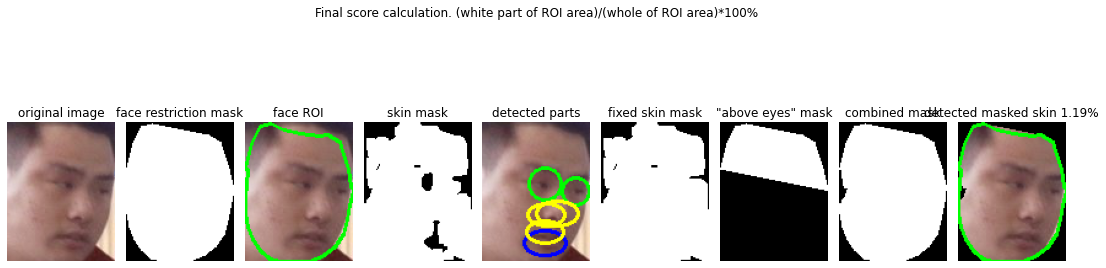

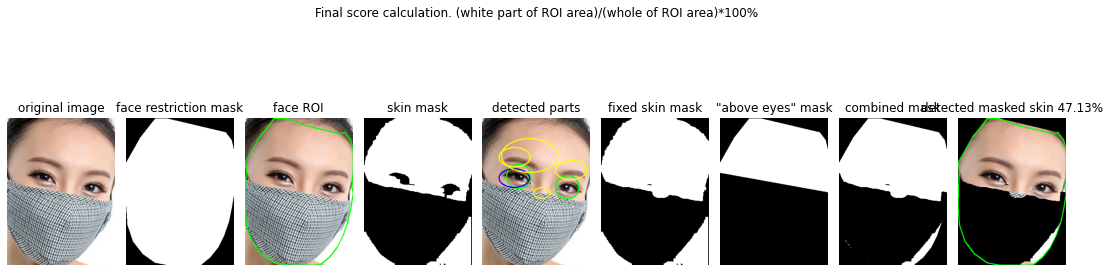

In [29]:
show_images([fu, fu_rm, fu_roi, fu_sm_clahe,
             fup, fu_fsm, fu_aem, fu_fm,
             draw_roi(fu_final, fu_pts)],
            ['original image', 'face restriction mask', 'face ROI', 'skin mask',
             'detected parts', 'fixed skin mask', '"above eyes" mask', 'combined mask',
             f'detected masked skin {str(np.round(fu_perc*100, 2))}%'],
            suptitle='Final score calculation. (white part of ROI area)/(whole of ROI area)*100%')

show_images([fm, fm_rm, fm_roi, fm_sm_clahe,
             fmp, fm_fsm, fm_aem, fm_fm,
             draw_roi(fm_final, fm_pts)],
            ['original image', 'face restriction mask', 'face ROI', 'skin mask',
             'detected parts', 'fixed skin mask', '"above eyes" mask', 'combined mask',
             f'detected masked skin {str(np.round(fm_perc*100, 2))}%'],
            suptitle='Final score calculation. (white part of ROI area)/(whole of ROI area)*100%')

## Final result
---
Detected faces with annotation of masking percentage.

In [30]:
_, _, _, final_unmasked = example(iu, highlight_masking=True)
_, _, _, final_masked = example(im, highlight_masking=True)

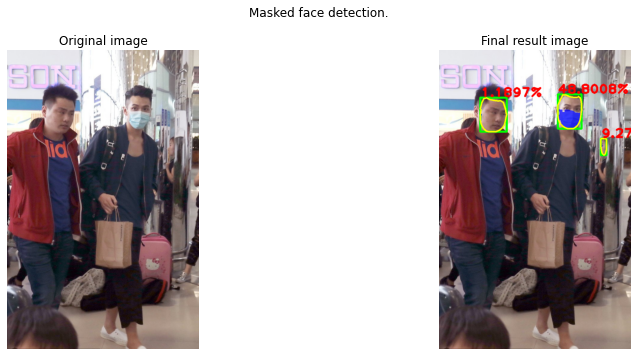

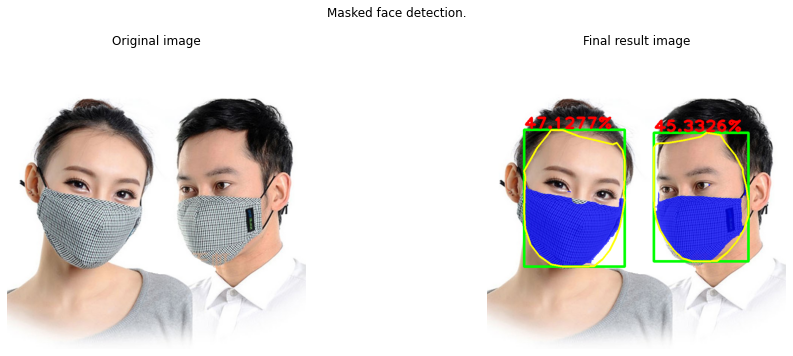

In [31]:
show_images([iu, final_unmasked],
            ['Original image', 'Final result image'],
            suptitle='Masked face detection.')

show_images([im, final_masked],
            ['Original image', 'Final result image'],
            suptitle='Masked face detection.')

## Examples

In [32]:
img1 = Image.open('silh_images/51_Dresses_wearingdress_51_313.jpg')
_, _, _, final_img1 = example(img1, highlight_masking=True)

img2 = Image.open('silh_images/52_Photographers_photographertakingphoto_52_530.jpg')
_, _, _, final_img2 = example(img2, highlight_masking=True)

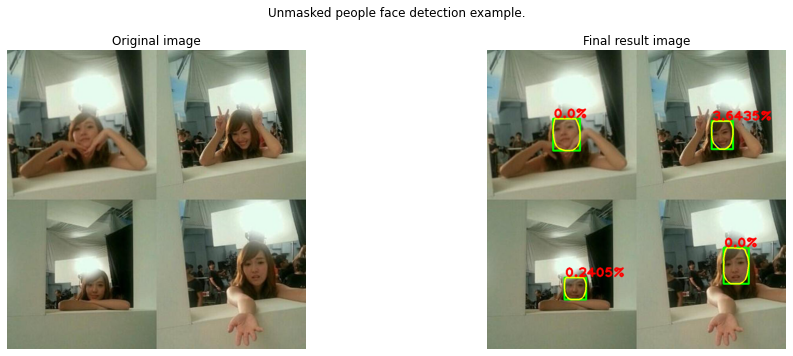

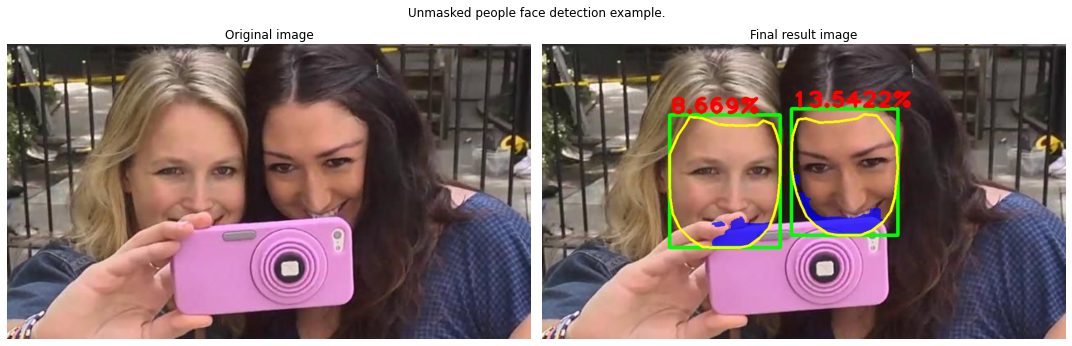

In [33]:
show_images([img1, final_img1],
            ['Original image', 'Final result image'],
            suptitle='Unmasked people face detection example.')

show_images([img2, final_img2],
            ['Original image', 'Final result image'],
            suptitle='Unmasked people face detection example.')

In [34]:
img1 = Image.open('images/masked2.png')
_, _, _, final_img1 = example(img1, highlight_masking=True)

img2 = Image.open('images/masked3.png')
_, _, _, final_img2 = example(img2, highlight_masking=True)

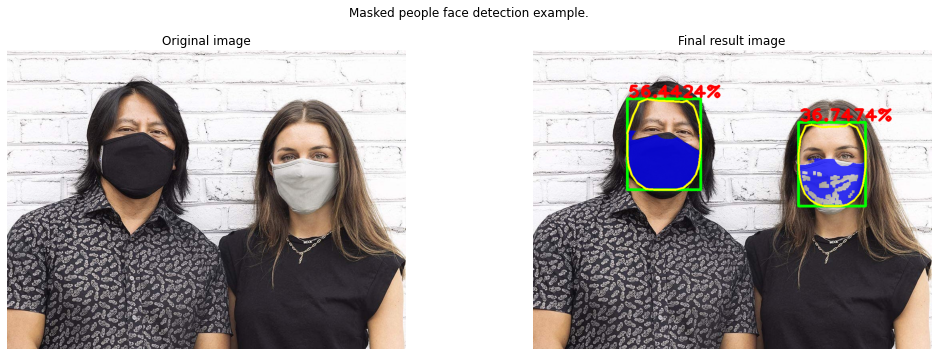

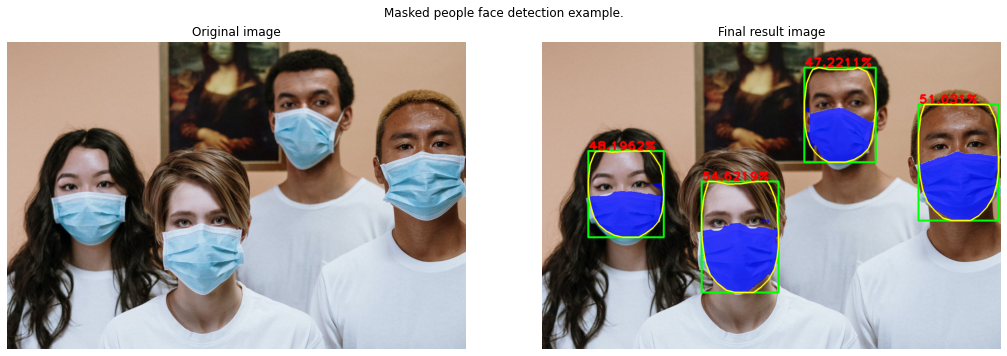

In [35]:
show_images([img1, final_img1],
            ['Original image', 'Final result image'],
            suptitle='Masked people face detection example.')

show_images([img2, final_img2],
            ['Original image', 'Final result image'],
            suptitle='Masked people face detection example.')

In [36]:
img1 = Image.open('images/masked6.png')
_, _, _, final_img1 = example(img1, highlight_masking=True)

img2 = Image.open('images/masked7.png')
_, _, _, final_img2 = example(img2, highlight_masking=True)

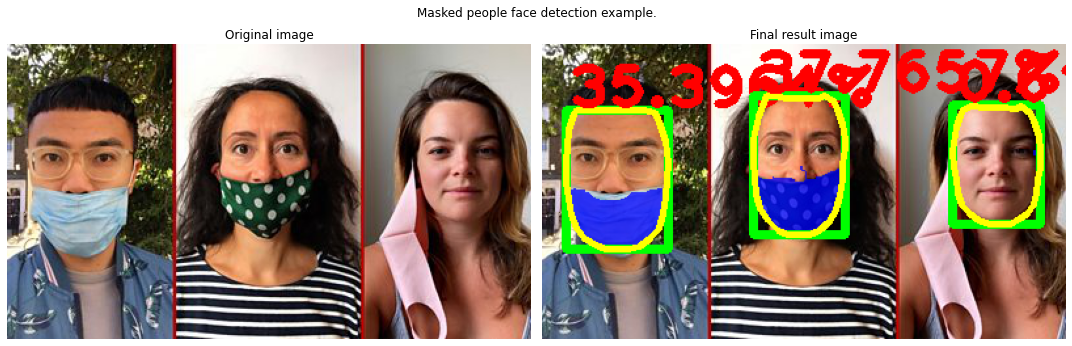

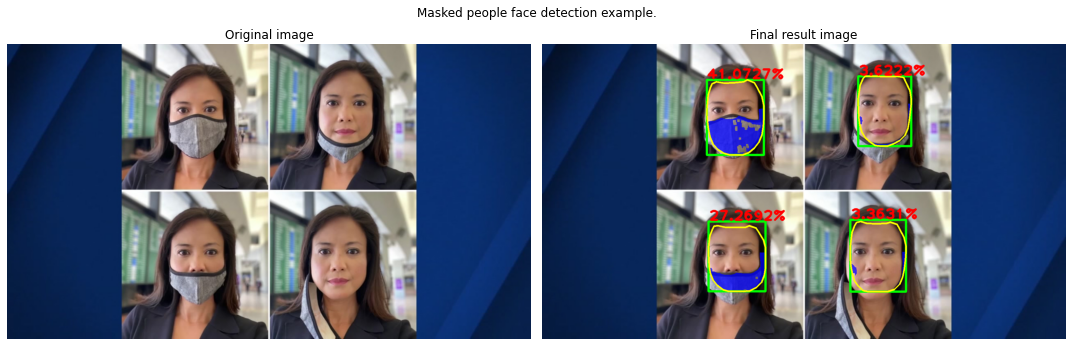

In [37]:
show_images([img1, final_img1],
            ['Original image', 'Final result image'],
            suptitle='Masked people face detection example.')

show_images([img2, final_img2],
            ['Original image', 'Final result image'],
            suptitle='Masked people face detection example.')

In [38]:
img1 = Image.open('images/masked_criminal2.png')
_, _, _, final_img1 = example(img1, highlight_masking=True)

img2 = Image.open('images/masked_criminal3.png')
_, _, _, final_img2 = example(img2, highlight_masking=True)

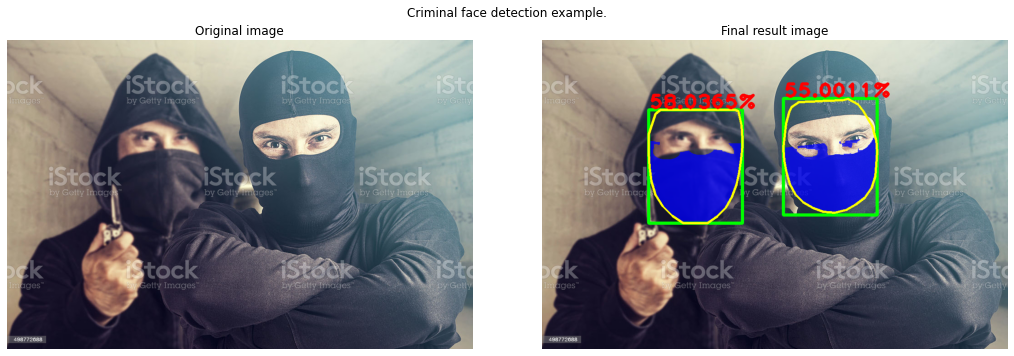

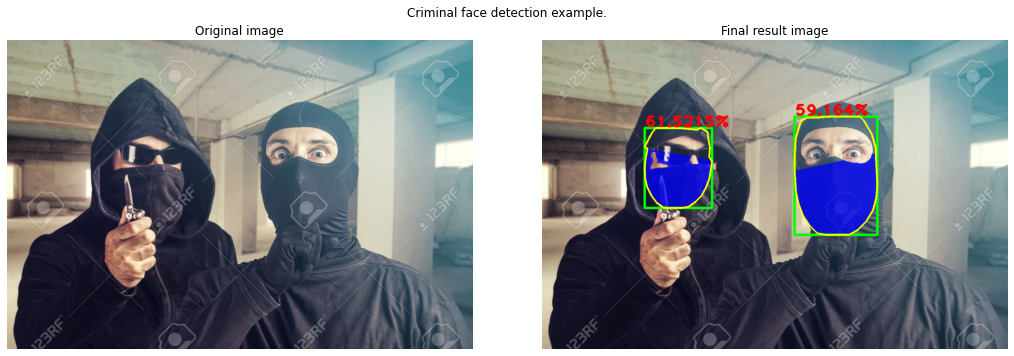

In [39]:
show_images([img1, final_img1],
            ['Original image', 'Final result image'],
            suptitle='Criminal face detection example.')

show_images([img2, final_img2],
            ['Original image', 'Final result image'],
            suptitle='Criminal face detection example.')